<a href="https://colab.research.google.com/github/ahmadryan/MLTSA_RQudsi/blob/master/HW6_RQudsi/FeatureEngineering_PLAsTIcCchallenge_2_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PART 2 of the Plassticc challenge homework: implement classification and clustring on the feature space you created in the previous homework

## this homework is split into 2. In the first part, due by Thursday 9th at noon, you will engineer features from time series. In the second half, due Thursday 16th at noon, you will use those features to find structure in the feature space (unsupervised learning, i.e. clustering) and classify by example with CART (supervised learning with random forest or gradient boosted tree models)

# Classifying astrophysical transients from photometry

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in the light emission in 6 different bands. The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good riend Gautham Narayan in fact!) to get started and ingest and preprocess the PLASTiCC challenge data. However, this is written with a class (object oriented) and we have not talked about this syntax in class. If you are not familiar with classes do not worry about it (but you should learn them!). Also I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and run 2 models on these feautes: a cluster model, and a classification tree. 

To limit confusion I removed the first part of the notebook. You can find it in https://github.com/fedhere/MLTSA_FBianco/tree/master/HW5 in the solution notebook


**NOTE I HAD A MISTAKE IN THE NOTEBOOK LAST WEEK! you want to scale for the full set at once, and save the values of mean and standard deviation of the full set so you can preprocess future observations that are in nither sets the same way**



In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from numpy import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd gdrive/My\ Drive/

/content/gdrive/My Drive


In [4]:
cd data/

/content/gdrive/My Drive/data


In [5]:
# NOTE::: this is not a reproducible way to do it!!!!!! this would cost points

lcvs = pd.read_csv("plasticc_train_lightcurves.csv.gz")

# The Zenodo data include 1.4 million datapoints. 
## -- I am subsampling the data to develop the code 
# by using only the first 10000 datapoints (lcvs[:10000])
## -- When I am done I will run this on the larger dataset (commenting out #[:10000])
## note that I am choosing the first N=1000, as opposed to 1 every 100 or whatever 
## because there are 6 time series per obects in 6 filters (colors)

lcvs = lcvs#[:10000]
print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (1421705, 6)


In [6]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [8]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [9]:
metadata = pd.read_csv("plasticc_train_metadata.csv.gz")
metadata

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.7188,-14.9403,0,0.000,0.000,0.000,-9.000,0.013,65,65,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,18232,26.4,267.6,742.8,3295.1,6047.5,7955.2
7844,130755807,120.1013,-62.6967,0,0.172,2.561,1.115,46.611,0.136,90,90,1,0.172,39.595,-0.001,-12.8,0.0,0.0,60056.809,14934,0.0,0.0,0.0,0.0,0.0,0.0
7845,130762946,203.1081,-55.6821,0,0.000,0.000,0.000,-9.000,0.430,16,16,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,47805,83.8,1124.7,1445.1,1191.2,848.9,382.5
7846,130772921,79.1016,-35.5018,0,0.000,0.000,0.000,-9.000,0.034,65,65,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,22240,1.9,14.4,49.4,244.3,534.8,897.2


In [46]:
print("The metadata dataset contains more information for each time series: (time-series, columns)", metadatan.shape)

The metadata dataset contains more information for each time series: (time-series, columns) (7848, 26)


In [0]:
# preparing a normalization to pass to the color map to map red filters to red blue filters to blue
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

In [0]:
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds =  lcvs.groupby(["object_id", "passband"])[["flux"]].std()

In [0]:
features = means.rename({"flux": "mean"}, 
                        axis=1).merge(stds.rename({"flux": "std"}, 
                                axis=1), left_index=True, right_index=True)

In [14]:
features.head()

mean         std
object_id passband                        
615       0          -3.254554   83.944735
          1        -385.699911  601.787302
          2        -134.146566  455.121346
          3        -121.103501  335.425053
          4         -55.954592  291.803449

In [15]:
%%time
from scipy import stats 
def moment_computation(x, moment_order):
    '''Define a function to compute moment of a distribution given the 
    distribution and order of moment
    '''
    return stats.moment(x, moment = moment_order)
variance = lcvs.groupby(["object_id", "passband"])["flux"].apply(
                                       moment_computation, moment_order=2 )
skewness = lcvs.groupby(["object_id", "passband"])["flux"].apply(
                                       moment_computation, moment_order=3 )
kurtosis = lcvs.groupby(["object_id", "passband"])["flux"].apply(
                                       moment_computation, moment_order=4 )

CPU times: user 33.9 s, sys: 432 ms, total: 34.4 s
Wall time: 33.8 s


In [0]:
features['variance'] = variance
features['skewness'] = skewness
features['kurtosis'] = kurtosis

In [0]:
maxs = lcvs.groupby(["object_id", "passband"])["flux"].max()
mins =  lcvs.groupby(["object_id", "passband"])["flux"].min()

In [0]:
features["maxs"] = maxs
features["mins"] = mins

In [19]:
%%time
max_std = lcvs.groupby(["object_id", "passband"])["flux"].transform(lambda x: (x - x.mean()) / x.std())
max_std

CPU times: user 32.7 s, sys: 344 ms, total: 33 s
Wall time: 32.9 s


In [0]:
def normalize_by_group(df, by):
    groups = df.groupby(by)
    # computes group-wise mean/std,
    # then auto broadcasts to size of group chunk
    mean = groups.transform(np.mean)
    std = groups.transform(np.std)
    return (df[mean.columns] - mean) / std

In [21]:
%%time
def normed_max(x) :
    return max(( x -  x.mean() ) /x.std())

max_std = lcvs.groupby(["object_id", "passband"])["flux"].apply(normed_max)

CPU times: user 25.2 s, sys: 9.06 ms, total: 25.3 s
Wall time: 25.3 s


In [22]:
%%time
def normed_min(x) :
    return min(( x -  x.mean() ) /x.std())

min_std = lcvs.groupby(["object_id", "passband"])["flux"].apply(normed_min)

CPU times: user 25.2 s, sys: 6.08 ms, total: 25.2 s
Wall time: 25.2 s


In [0]:
features["max_std"] = max_std
features["min_std"] = min_std

In [24]:
%%time

# normalize each LC this is very slow. can you make  it faster?
def normed(df):
    return ( df -  df.mean() ) /df.std()

lcvs['fluxnormed'] = lcvs.groupby(["object_id", "passband"])["flux"].apply(normed)
lcvs['fluxnormed_err'] = lcvs.groupby(["object_id", "passband"])["flux_err"].apply(normed)
# this is how it could be done in a for loop. But it would take hours!!
#for obj in  objects:
#    for band in bands:
#        lcvs[lcvs.object_id == obj][lcvs.passband == band].normedflux =\
#             lcvs[lcvs.object_id == obj][lcvs.passband == band].flux - means.loc[obj, band]
#        lcvs[lcvs.object_id == obj][lcvs.passband == band].normedflux /= stds.loc[obj, band]        

CPU times: user 54.1 s, sys: 683 ms, total: 54.8 s
Wall time: 54.3 s


In [0]:
maxs_standardized = lcvs.groupby(["object_id", "passband"])["fluxnormed"].max()
mins_standardized = lcvs.groupby(["object_id", "passband"])["fluxnormed"].min()

In [0]:
medians = lcvs.groupby(["object_id", "passband"])[["fluxnormed"]].median()

In [0]:
features['median_std'] = medians

In [28]:
%%time
def linfit(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars
linfits = lcvs.groupby(["object_id", "passband"]).apply(linfit)

CPU times: user 9.69 s, sys: 51.1 ms, total: 9.74 s
Wall time: 9.73 s


In [0]:
slopes = [x[0] for x in linfits.values[:]]
intercepts = [x[1] for x in linfits.values[:]]

In [0]:
features["slopes"] = slopes
features["intercepts"] = intercepts

In [31]:
%%time

# this is slow!!
from statsmodels.formula.api import ols
def quadfit(x):
    x['t'] = x.mjd - x.iloc[0].mjd
    m1 = ols(formula='fluxnormed~t + 1', data=x).fit()
    m2 = ols(formula='fluxnormed~pow(t, 2) + t + 1', data=x).fit()
    
    pars = m2.llf, m1.llf, np.sign(m2.params[1])
    return pars
ols = lcvs.groupby(["object_id", "passband"]).apply(quadfit)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


CPU times: user 14min 48s, sys: 1.1 s, total: 14min 49s
Wall time: 14min 51s


In [0]:
ll1 = [x[0] for x in ols.values[:]]
ll2 = [x[1] for x in ols.values[:]]
ll3 = [x[2] for x in ols.values[:]]
features["ll1"] = ll1
features["ll2"] = ll2
features["ll3"] = ll3

In [0]:
# unstack will do the trick ... 
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])

In [170]:
allfeatures = allfeatures.merge(metadata[["object_id", "decl", "ddf_bool", "hostgal_photoz", 
                                          "hostgal_photoz_err", "target"]], on=['object_id']).drop("object_id", axis=1)
allfeatures.head()

KeyError: ignored

In [47]:
print("My feature space is {:2} features (columns)".format(len(allfeatures.columns)))

My feature space is 90 features (columns)


In [48]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - (np.isfinite(allfeatures).sum().sum())))

there are 0 NaN and 1 infinity entries


In [49]:
np.isfinite(allfeatures).sum()

passband            
0         mean          7848
          std           7848
          variance      7848
          skewness      7848
          kurtosis      7848
                        ... 
5         slopes        7848
          intercepts    7848
          ll1           7848
          ll2           7848
          ll3           7848
Length: 90, dtype: int64

In [50]:
## dropping the observation
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna().shape

((7848, 90), (7847, 90))

In [51]:
## dropping the feature
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1).shape

((7848, 90), (7848, 89))

In [52]:
## filling with something else
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).fillna(-99)

((7848, 90),
 passband            0                             ...          5                
                  mean          std      variance  ...        ll1        ll2  ll3
 object_id                                         ...                           
 615         -3.254554    83.944735  6.934866e+03  ... -76.917754 -77.386461 -1.0
 713         -2.720398     7.113509  4.987913e+01  ... -65.167686 -65.424297 -1.0
 730         -0.048080     1.828872  3.298318e+00  ... -66.518080 -67.853917  1.0
 745          1.797523     4.374445  1.886999e+01  ... -64.783463 -77.536999 -1.0
 1124         0.660948     2.360084  5.481586e+00  ... -76.526495 -76.666778  1.0
 ...               ...          ...           ...  ...        ...        ...  ...
 130739978    1.286655    15.998517  2.408965e+02  ... -47.963730 -48.247356  1.0
 130755807   24.635243    79.713932  5.824785e+03  ... -47.569288 -47.724129 -1.0
 130762946   -0.282914    46.605187  2.004963e+03  ... -43.413986 -43.476462 -1.0
 13

In [0]:
# -- personally I choose to drop the feature 
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# PART II: I already guided you  through some of these tasks, but sort of "blindly". Start from here for part 2: we will reperform some of the tasks more thoughtfully (and correctly) and you will apply both clustering and classification to the PLASTiCC challenge data

# PART IIA : Preprocessing


## Task II.1: Preprocess your features by scaling them along the feature axis

Scale your training and test sets to remove the correlation: each feature is preprocessed so that it is mean=0 and standard deviation =1 - we will talk about it in class but make sure you deliver in this notebook the scaled features as below. Save the original mean and standard deviation for all features

**Deliverable II.1: the means and standard deviation arrays and the scaled features array**

In [55]:
allfeatures

passband            0                             ...          5                
                 mean          std      variance  ...        ll1        ll2  ll3
object_id                                         ...                           
615         -3.254554    83.944735  6.934866e+03  ... -76.917754 -77.386461 -1.0
713         -2.720398     7.113509  4.987913e+01  ... -65.167686 -65.424297 -1.0
730         -0.048080     1.828872  3.298318e+00  ... -66.518080 -67.853917  1.0
745          1.797523     4.374445  1.886999e+01  ... -64.783463 -77.536999 -1.0
1124         0.660948     2.360084  5.481586e+00  ... -76.526495 -76.666778  1.0
...               ...          ...           ...  ...        ...        ...  ...
130739978    1.286655    15.998517  2.408965e+02  ... -47.963730 -48.247356  1.0
130755807   24.635243    79.713932  5.824785e+03  ... -47.569288 -47.724129 -1.0
130762946   -0.282914    46.605187  2.004963e+03  ... -43.413986 -43.476462 -1.0
130772921    3.374208    14.420201  1.930892e+02  ... -54.802358 -55.380808  1.0
130779836  812.700937  2120.766511  4.151677e+06  ... -25.400889 -25.425073  1.0

[7848 rows x 89 columns]

In [0]:
X = allfeatures.iloc[:,:-1].values
y = allfeatures.iloc[:,-1].values

In [62]:
featuremeans = allfeatures.mean().values
featurestd = allfeatures.std().values
print("saved means and standard deviation arrays", featuremeans, featurestd)
print("number of observcations {}, features {}, means {}, standard deviations {}".format(
    *X.shape, featuremeans.shape[0], featurestd.shape[0]))

saved means and standard deviation arrays [ 3.92737631e+01  2.18255899e+02  1.17402466e+08  9.32087443e+13
  3.41670025e+20  5.23882191e+02 -2.47707666e+02  2.25065757e+00
 -1.62773232e+00 -7.30978852e-02  3.24319722e-04  6.37471557e-03
 -3.23453304e+01  8.15494393e-03  2.96187944e+01  1.88291251e+02
  1.26600038e+06  3.16596717e+10  4.75957697e+15  3.87999042e+02
 -1.88841777e+02  2.54866973e+00 -1.30848432e+00 -1.58191816e-01
 -4.47031168e-03  2.58871203e-02 -2.76154050e+01 -2.96436596e+01
  5.37716616e-02  4.29330082e+01  2.04791323e+02  3.54331510e+06
  1.68105011e+11  8.87945300e+16  4.84962221e+02 -2.16683247e+02
  3.05009638e+00 -1.25648291e+00 -2.01574134e-01 -2.48675518e-03
  3.19192091e-02 -3.65387768e+01 -3.96869617e+01  8.53720693e-02
  4.42794190e+01  1.98862866e+02  4.83654718e+06  2.76767695e+11
  1.82763818e+17  4.76626366e+02 -1.95807404e+02  2.94933990e+00
 -1.30670126e+00 -1.94071059e-01 -1.69153033e-03  2.11262820e-02
 -3.56182235e+01 -3.88739946e+01  6.85524975e-02

In [63]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
print("scaled training data feature mean and standard deviations: ", 
      X_scaled.mean(axis=0), X_scaled.std(axis=0))



scaled training data feature mean and standard deviations:  [ 5.43228391e-18 -3.62152261e-18  1.81076130e-18 -2.71614196e-18
 -3.62152261e-18 -2.71614196e-18  3.62152261e-18  5.79443617e-17
  0.00000000e+00  2.17291357e-17  1.08645678e-17  7.24304522e-18
  0.00000000e+00  6.51874070e-17  5.88497424e-18 -4.07421293e-18
  6.33766456e-18  3.62152261e-18 -2.71614196e-18  5.43228391e-18
  1.26753291e-17  0.00000000e+00  3.62152261e-17 -1.08645678e-17
  4.52690326e-18 -1.04118775e-17  1.15888723e-16  5.79443617e-17
 -2.53506583e-17 -3.62152261e-18  1.00723598e-17  0.00000000e+00
 -4.52690326e-18  1.81076130e-18 -4.52690326e-19  5.43228391e-18
  1.44860904e-17  1.62968517e-17  3.62152261e-18  1.17699485e-17
 -3.16883228e-18 -5.79443617e-17  0.00000000e+00  1.23131769e-16
  1.81076130e-18 -4.97959359e-18  1.81076130e-18  0.00000000e+00
 -9.05380652e-19  1.81076130e-18 -1.26753291e-17  2.89721809e-17
  1.44860904e-17 -1.44860904e-17 -1.08645678e-17 -2.26345163e-18
  0.00000000e+00 -5.79443617e-

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "



# Task II.2: You already did this in part I: you do not have to do it again if you are satisfied with what you did, but retun this since you redid the scaling of the features: Visualize a large dimensional feature space to plan the analysis and produce a 2D t-SNE projection of your feature space and visualize it. 
If you are lucky, this will be a pretty plot!
a great model to **Visualize** structure in data is  t-SNE: t-distributed Stocastic Neighbourhood Embedding
It project N-dimensional data on a 2-dimensional surface preserving the N-dimensional distance. If thre is structure in the feature space, it should show. If there is structure in feature space, clustering is a promising technique.


In [0]:
from sklearn.manifold import TSNE

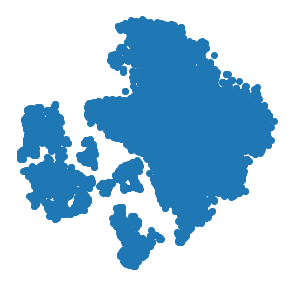

Figure: the 2D projection of the ~70-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledianpairwise distances existing in the higher dimensional parameter space. How many clusters can you see in this embedding?A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, this is the only cxase in which you are allowed not to label your axes!


In [66]:
%%time

X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X_scaled)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.axis('off')
pl.show()

## Figure1:
The 2D projection of the ~90-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising:t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledian pairwise distances existing in the higher dimensional parameter space. 7 clusters are visible in the figure.

We have to assure that the clusters map to the target variable tho. So I will redo the plot colorcoded by target variable

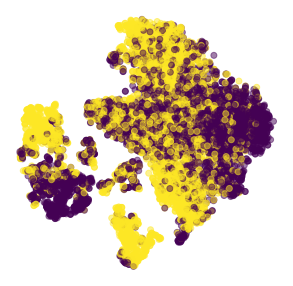

In [67]:
norm_obj= Normalize(vmin=y.min(), vmax=y.max())
len([c for c in pl.cm.RdBu_r(norm_obj(y))]), X_embedded.shape
pl.figure(figsize=(5,5))
pl.axis('off')
pl.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y))], alpha=0.5);

Figure: the purity of the sample is not good in the t-SNE projection against the target variable. The colors are mixed in most t-SNE clusters, the highest purity is achieved near the center of the projected feature space. **This is not a particularly promising situation**

Does this map better on other features in the metadata?



**Deliverable II.2: make your version of the plot below, and discuss your own result, which will likely be somewhast different from mine. Do you see any other insightful mapping of the features in the t-SNE projection?**

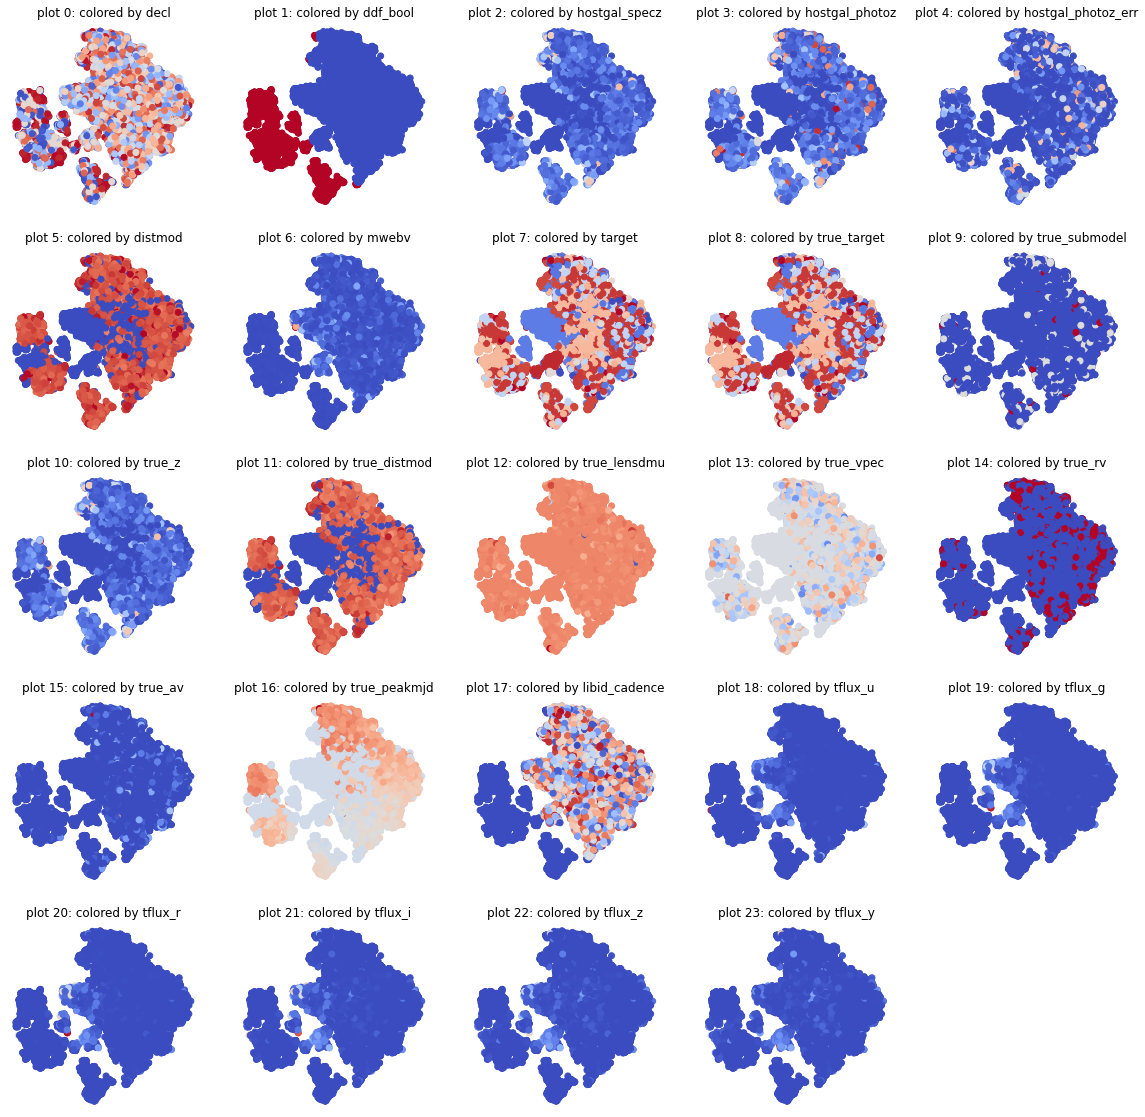

In [68]:
fig = pl.figure(figsize=(20,20))
# note: I am avoiding the first column of metadata which is the object identifier
for i, col in enumerate(metadata.columns[1:]):
    ax = fig.add_subplot(5,5,i+1)
    v = metadata[col].astype(float)
    ax.set_title("plot %d: colored by %s"%(i,col))
    ax.scatter(X_embedded[:,0], X_embedded[:,1],  
               color=[pl.cm.coolwarm(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])
    ax.axis('off')

    #pl.show()

Figure : the feature space is projected on a 2D plane via t-SNE method, and the points are colorcoded by the value of all metadata: this includes features used in the feature space as well as features that are not used in the feature space. The fueature space t-SNE projection does not map the metadata, except for the survey: **row 1 and column 3** the data includes a DeepDrillingField survey and a regular survey (called wide-fast-deep) which include different observation strategy decisions (data collection strategy). Those are obviously affecting the data features this the clear split of the cluster in row 1 column 3.  (The deep drilling fields are special regions of the sky that would be observed more frequently, a whole bunch of times in one night. So even if an object were the same kind of object the extracted features could be very different!).

Most other features map the t-SNE projection more poorly. 


# PART IIB : Clustering 
## cluster the data using Agglomerative and DBscan. 
    


In [0]:
from sklearn.cluster import AgglomerativeClustering

Here is how I could cluster the data using the Euclidian distance with Agglomeratie Clustering stoopping the algorithm at 3 clusters. The Eucledian distance is the default for this (and most other) clustering algorithms implemented in sklearn. 

- Note: I can use the Eucledian distance **because** I preprocessed the feature space and all features have the same standard deviation!* 

- Note: the AgglemerativeClustering implementation in python allows to specify the number of clusters (I will use 3): the agglomeration will stop there for efficiency, this is not the same as having to specify the number of clusters in k-means, where the result depends on the number of clusters. In agglomerative clustering the following clusters would be segmentations of the first 2. 



elements in cluster 0 4829
elements in cluster 1 1138
elements in cluster 2 1879
elements in cluster 3 1
elements in cluster 4 1



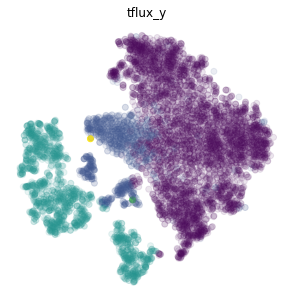

Figure: clustering the 90 dimensional feature space based on Agglomerateive Clustering algorithm with Eucledian distance into 3 clustersThere are 2 clusters of several observations, mapping excellently to the t-SNE projectionOne cluster of one indicates the presence of an outlier


In [87]:
clustering = AgglomerativeClustering(n_clusters=3).fit(X_scaled)

for j in range(3):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
print()
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()
print("Figure: clustering the 90 dimensional feature space based on " + 
      "Agglomerateive Clustering algorithm with Eucledian distance into 3 clusters" + 
     "There are 2 clusters of several observations, mapping excellently to the t-SNE projection" + 
     "One cluster of one indicates the presence of an outlier")



In [81]:
j

2

## TASK II.3:  Use AgglomerativeClustering in sklearn allows to select the number of cluster, run AgglomearativeCLustering with 2,3,4,5,6 clusters with Eucledian distance. Comment on the results.

**Deliverable II.3: plot the clusters obtained with AgglomerativeClustering with n_custer 2...6 and Eucledian distance, and comment on the result (mapping on t-SNE, outliers, consistence between the results obtained with different number of clusters)**


elements in cluster 0 7847
elements in cluster 1 1



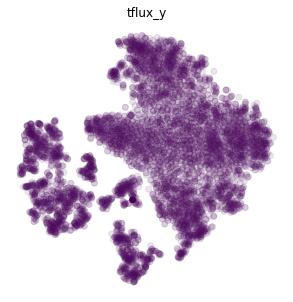

elements in cluster 0 5968
elements in cluster 1 1
elements in cluster 2 1879



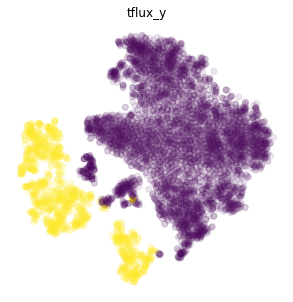

elements in cluster 0 5967
elements in cluster 1 1
elements in cluster 2 1879
elements in cluster 3 1



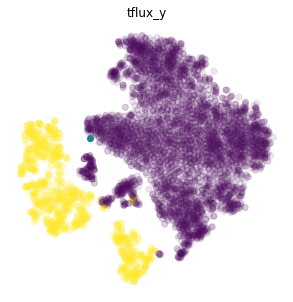

elements in cluster 0 4829
elements in cluster 1 1138
elements in cluster 2 1879
elements in cluster 3 1
elements in cluster 4 1



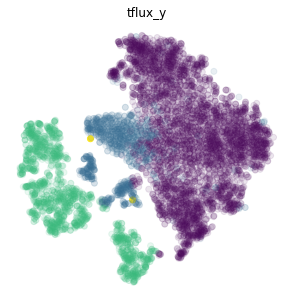

In [91]:
for n in range(2,6):
    clustering = AgglomerativeClustering(n_clusters=n).fit(X_scaled)

    for j in range(n):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
    print()
    pl.figure(figsize=(5,5))
    pl.title(col)

    #using a color map normalized according to the number of clusters:
    # for 3 clusters vmin=0, vmax=2
    colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=j-1)(c))
                                                         for c in clustering.labels_])
    # changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
    alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 2 else 1.0 for j in clustering.labels_])
    # setting the alpha channel by replacing the default of the colormap which is 1
    colors[:,3] = alpha
    
    pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
                color=colors);
    pl.axis('off')
    pl.show()

Figure: ....

## let's take a look at outliers: in the AgglomerativeClustering (n_cluster=2) there is one outlier**

## Extra Credit 1: If you have clusters where you have single object in a cluster (e.g. in my Agglomerative Cluastering with n_cluster=2) try and figure out how why the object that is an outlier and isolated by your clustering model. 

I plotted all objects of the same type as the outlier in the 3-clusters result, but this was not very insightful. Can you do better?

## TASK II.4 what happens if I change the distance metric?

Create a new metric: precompute the braycurtis metric with scipy.spatial.distance.cdist and pass it to the accolmerative clustering with n_clusters=3 and affinity='precomputed'. Describe the result. Look online, on the documentation of scipy and on the any statistical resources (wikipedia has great pages on this) to describe the braycurtis distance.

**Deliverable: make a plot of the t-SNE projection colorcoded by the cluster obtained with the precomputed braycurtis distance and comment on whether it is consistent with the Eucledian distance clustering result.**

In [0]:
from scipy.spatial.distance import cdist

In [0]:
clustering = AgglomerativeClustering(n_clusters=n).fit(X_scaled)

In [98]:
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

In [101]:
X_scaled.shape

(7848, 88)

In [102]:
dist = cdist(X_scaled, X_scaled, metric='braycurtis')
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
                                    linkage="complete").fit(dist)
for j in range(2, -1, -1):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))


elements in cluster 2 1928
elements in cluster 1 2089
elements in cluster 0 3831


elements in cluster 0 3831
elements in cluster 1 2089
elements in cluster 2 1928



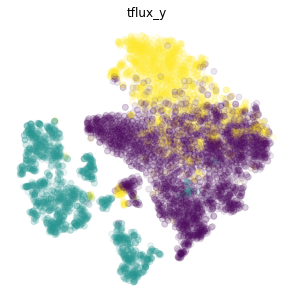

Figure: clustering the 90 dimensional feature space based on Agglomerateive Clustering algorithm with Eucledian distance into 3 clustersThere are 2 clusters of several observations, mapping excellently to the t-SNE projectionOne cluster of one indicates the presence of an outlier


In [103]:
for j in range(3):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
print()
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()
print("Figure: clustering the 90 dimensional feature space based on " + 
      "Agglomerateive Clustering algorithm with Eucledian distance into 3 clusters" + 
     "There are 2 clusters of several observations, mapping excellently to the t-SNE projection" + 
     "One cluster of one indicates the presence of an outlier")

## Extra Credit II : Also cluster the original, not scaled features but use the Mahalanobis distance, which takes into account the variance of a feature and comment on the result. Is it consistent with the result using Eucledian distance on the scaled feature space

In [0]:
...

## Extra Credit III: What happens if you change clustering strategy?
Cluster the features with DBScan. DBScan is the most cited clustering method. It is density based clustering: it allows you to specify a distance metric, and a minimum distance and number of neightbours within that distance for a point to be considered part of a cluster. Choose and justify your choice on the following parameters 
- eps: the maximum distance between two observations to be in the same cluster
- min_sample: the minimum number of neighbours a cluster needs to have to be a cluster (and not an outlier)



In [0]:
DBclustering = sklearn.cluster.DBSCAN(eps=.., min_samples=.., metric='euclidean', 
                       metric_params=None, algorithm='auto', leaf_size=30).fit(X_scaled)
...

# what have we learned?...
This was actually very helpful to understand that there are 2 surveys which split into 2 cluster under most cluster parameter choices. Other than that... I am not sure. And this happens a lot to me with clustering to be frank. 
- In many cases above (e.g. AgglomerativeClustering(n_clusters=3).fit(X_scaled) ) the clustring reflected a split that was obvious in the t-SNE visualization of the feature space: a large cluster on the top right of my plot, a more diffuse and structured cluster in the bottom left. This splits the deep drilling fields observations from the regular survey observations. It is good and it makes sense that we get that split, but it is not particularly insightful scientifically cause it tells us about the kind of observations we did, not the nature of the objects.

- In some cases clusters of one (in the Agglomarative clustering) or outliers are identified (DBscan) but in a 79-dimensioanl parameter space it is hard to see what that really means... why is a "outlier" different? In fact this challenge was purposefully designed to have no outliers in the training set (which is what we used) and have outliers in the test set. So our "outliers" should not be outliers. And if we change the parameters in the DBscan they are clustering changes indeed!




# PARTH IIB: Classifying:
Unlike clustering, classifying requires the existance of examples - we are learning by example how to spli tobervations among classes. We already prepared the train and test samples. 

Notice that tree methods do not require scaling or whitening! Why? because they deal with each feature one by one, so they make no assumption about covariance of features (until you try to do feature importance) **you can use the original X for the tree-based classification**

# TASK II.4 We will treat the 2 surveys separately: the general survey, and the deep drilling fields. 

splut the sample into DDF and normal and split each of those into training and test set

**Deliverable: 2 training and 2 test sets, one for DDF and one for the normal survey**



In [159]:
print("breakdown between surveys {} {}".format(
    (metadata.ddf_bool == 1).sum(), (metadata.ddf_bool == 0).sum()))

breakdown between surveys 2116 5732


In [0]:
X = allfeaturesn.iloc[:,:-1].values
y = allfeaturesn.iloc[:,-1].values

Xddf = X[allfeaturesn.ddf_bool==1]
Xnormal = X[allfeaturesn.ddf_bool==0]
yddf =  y[allfeaturesn.ddf_bool==1]
ynormal =  y[allfeaturesn.ddf_bool==0]

In [163]:
allfeaturesn

,"(0, mean)","(0, std)","(0, variance)","(0, skewness)","(0, kurtosis)","(0, maxs)","(0, mins)","(0, max_std)","(0, min_std)","(0, median_std)","(0, slopes)","(0, intercepts)","(0, ll1)","(0, ll2)","(0, ll3)","(1, mean)","(1, std)","(1, variance)","(1, skewness)","(1, kurtosis)","(1, maxs)","(1, mins)","(1, max_std)","(1, min_std)","(1, median_std)","(1, slopes)","(1, intercepts)","(1, ll1)","(1, ll2)","(1, ll3)","(2, mean)","(2, std)","(2, variance)","(2, skewness)","(2, kurtosis)","(2, maxs)","(2, mins)","(2, max_std)","(2, min_std)","(2, median_std)",...,"(3, slopes)","(3, intercepts)","(3, ll1)","(3, ll2)","(3, ll3)","(4, mean)","(4, std)","(4, variance)","(4, skewness)","(4, kurtosis)","(4, maxs)","(4, mins)","(4, max_std)","(4, min_std)","(4, median_std)","(4, slopes)","(4, intercepts)","(4, ll1)","(4, ll2)","(4, ll3)","(5, mean)","(5, std)","(5, variance)","(5, skewness)","(5, kurtosis)","(5, maxs)","(5, mins)","(5, max_std)","(5, min_std)","(5, median_std)","(5, slopes)","(5, intercepts)","(5, ll1)","(5, ll2)","(5, ll3)",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,-3.254554,83.944735,6.934866e+03,7.266579e+04,7.433032e+07,125.182808,-116.913223,1.530023,-1.353970,-0.080537,0.005676,-0.175947,-84.013092,-88.218652,-1.0,-385.699911,601.787302,3.559040e+05,8.593916e+07,2.215166e+11,660.626343,-1100.440063,1.738698,-1.187696,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,-134.146566,455.121346,2.035641e+05,3.040627e+07,6.659406e+10,611.984558,-681.858887,1.639411,-1.203442,-0.289021,...,0.020475,-0.583524,-79.226482,-79.290039,-1.0,-55.954592,291.803449,8.368116e+04,4.717542e+06,1.036570e+10,381.953735,-422.184509,1.500696,-1.255057,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,-47.449847,294.779522,8.537049e+04,3.041829e+06,1.049535e+10,378.188141,-422.815094,1.443920,-1.273376,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,-61.9438,1,0.000,0.000,92
1,-2.720398,7.113509,4.987913e+01,8.963424e+01,4.907398e+03,14.509829,-14.735178,2.422184,-1.689009,-0.052914,-0.041433,1.429423,-45.801483,-49.801325,-1.0,-1.019804,5.712334,3.204807e+01,-1.551087e+01,1.944373e+03,9.129021,-11.715749,1.776651,-1.872430,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,-0.794238,5.770738,3.270675e+01,-4.127475e+00,1.935955e+03,10.529041,-10.067919,1.962189,-1.607018,0.117188,...,-0.050983,1.402038,-38.701863,-41.302700,-1.0,-0.900262,6.406989,4.031648e+01,-1.597455e+01,2.938985e+03,9.827934,-12.286801,1.674452,-1.777206,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,-1.794175,7.094073,4.942719e+01,7.377121e+01,5.294322e+03,14.770886,-14.211164,2.335056,-1.750333,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,-27.7844,1,1.627,0.255,88
2,-0.048080,1.828872,3.298318e+00,2.093148e+00,3.655013e+01,5.942166,-3.459960,3.275377,-1.865565,0.039463,-0.001798,0.063840,-101.249926,-101.606902,-1.0,0.141057,1.807229,3.203266e+00,2.623669e+00,3.870188e+01,5.693109,-3.393080,3.072136,-1.955556,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,2.400870,5.559483,3.031347e+01,3.864890e+02,6.926529e+03,20.994711,-2.848838,3.344527,-0.944280,-0.343392,...,0.024491,-0.624531,-66.369632,-66.683538,1.0,4.308728,10.710344,1.124622e+02,2.936931e+03,1.060595e+05,41.159981,-5.836310,3.440716,-0.947219,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,4.539396,13.332758,1.742769e+02,3.751336e+03,1.860606e+05,47.310059,-19.159811,3.207938,-1.777517,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,-6.5796,1,0.226,0.016,42
3,1.797523,4.374445,1.886999e+01,1.623684e+02,2.575248e+03,18.014029,-3.874349,3.707100,-1.296592,-0.169349,-0.013089,0.464675,-88.423048,-100.184915,-1.0,5.717394,25.964659,6.621249e+02,1.161627e+05,2.162844e+07,192.244293,-3.618410,7.183876,-0.359558,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,9.711532,31.957997,1.003076e+03,1.758302e+05,3.606109e+07,220.795212,-2.159753,6.605035,-0.371465,-0.290606,...,-0.003931,0.108112,-67.105516,-78.945375,-1.0,13.134436,33.06

In [165]:
Xddf.shape

(2116, 94)

then split training and test set

In [0]:
import sklearn
from sklearn.model_selection import train_test_split

X_trainddf, X_testddf, y_trainddf, y_testddf = train_test_split( Xddf, yddf, test_size=0.33, random_state=42, shuffle=True)

X_trainnormal, X_testnormal, y_trainnormal, y_testnormal = train_test_split( Xnormal, ynormal, test_size=0.33, random_state=42, shuffle=True)

In [167]:
X_trainddf

array([[ 2.20e+01,  8.34e+01,  6.72e+03, ...,  1.00e+00,  8.60e-02,
         2.50e-02],
       [-1.59e+01,  6.86e+00,  4.63e+01, ...,  1.00e+00,  1.44e+00,
         5.50e-02],
       [ 1.85e+01,  5.52e+01,  3.00e+03, ...,  1.00e+00,  3.25e-01,
         1.80e-02],
       ...,
       [ 3.73e+00,  1.04e+01,  1.07e+02, ...,  1.00e+00,  1.90e-01,
         1.30e-02],
       [ 7.21e-01,  3.05e+00,  9.18e+00, ...,  1.00e+00,  5.36e-01,
         1.50e-02],
       [ 2.16e-01,  2.05e+00,  4.14e+00, ...,  1.00e+00,  0.00e+00,
         0.00e+00]])

## TASK II.5 Classification with Random Forest 
 Below I will use  RandomForest  to classify objects predicting "target" according to the "target" variable of the in the mtadata dataframe for both DDF and normal survey. 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
**Deliverable: comment on the score: what does the number I obtained mean?**

## TASK II.6 Use GradientBoosted trees to redo the same classification 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

**Deliverable: the score obtained solving the classification problem with the GBT model and a comparison of the score obtained with the RF**

In [168]:
from sklearn.ensemble import RandomForestClassifier
clfddf = RandomForestClassifier(n_estimators=100, 
                        criterion='gini', max_depth=5).fit(X_trainddf, y_trainddf)
clfnormal = RandomForestClassifier(n_estimators=100, 
                        criterion='gini', max_depth=5).fit(X_trainnormal, y_trainnormal)

ValueError: ignored

## measuring the classification performance by using the test score
**Deliverable: comment on the score: what does the number I obtained mean?**

In [155]:
print("Random Forest Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           clfddf.score(X_testddf, y_testddf),
           clfnormal.score(X_testnormal, y_testnormal)))

Random Forest Classification
score on DDF 0.87 and on normal survey 0.73


Comment on what the numbers above mean...

# Because this is a classification problem, we can build a confusion matrix

Confusion matrix, without normalization
Normalized confusion matrix


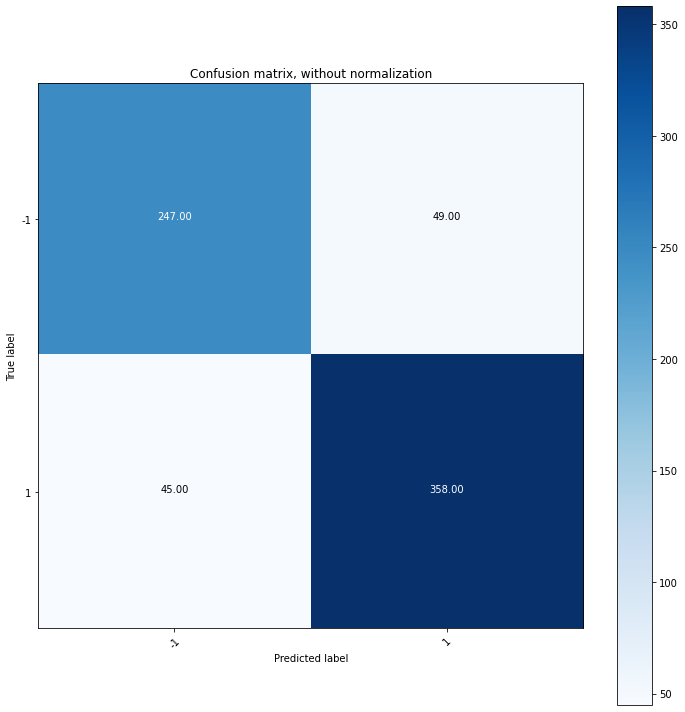

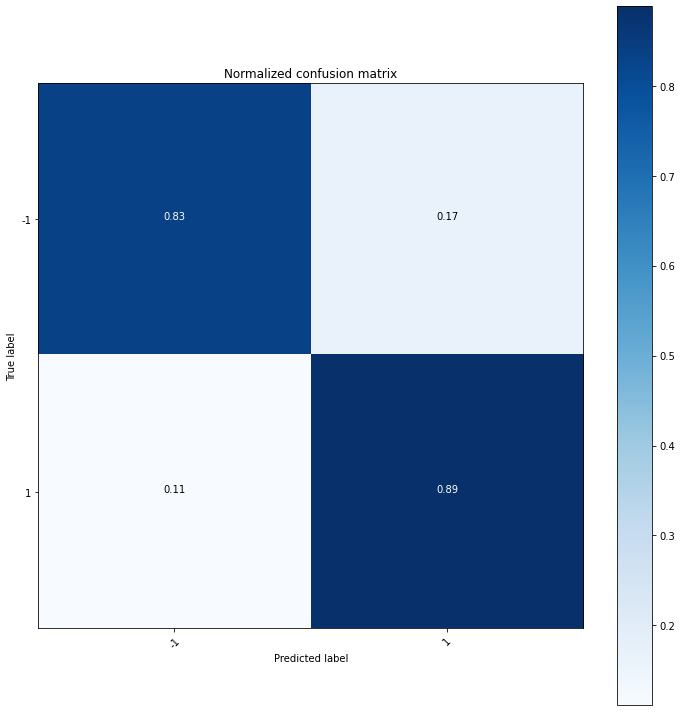

In [156]:
#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_testddf, clfddf.predict(X_testddf))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()



Confusion matrix, without normalization
Normalized confusion matrix


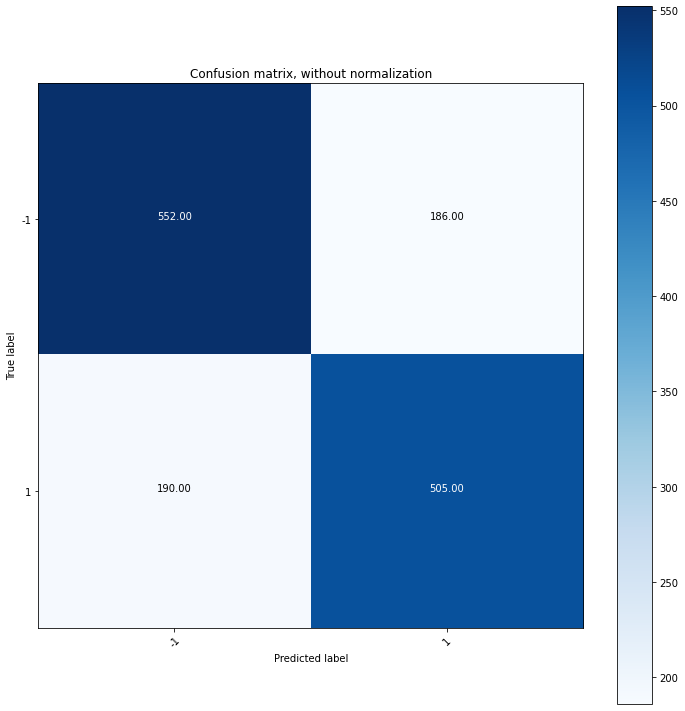

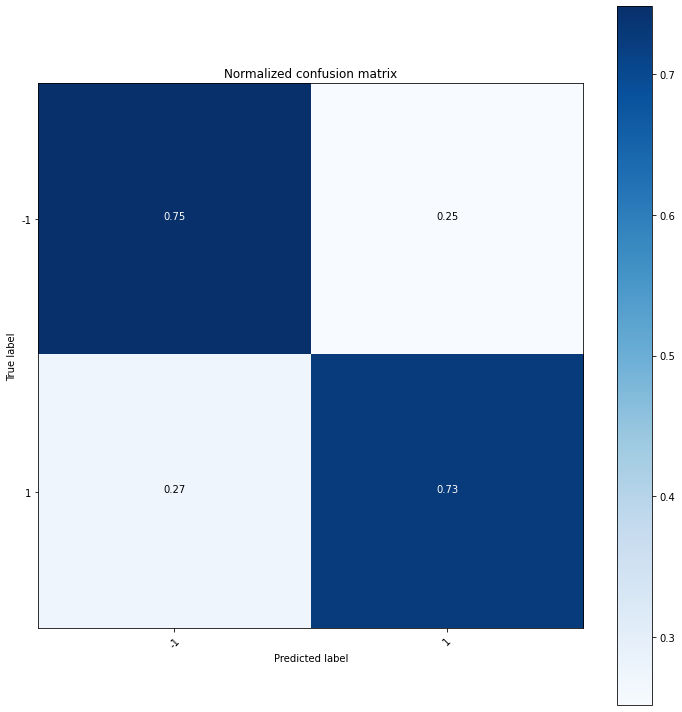

In [115]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_testnormal, clfnormal.predict(X_testnormal))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# TASK II.7 take a stab at interpreting this. We will discuss in class how to read this properly on tuesday

# Extra Credit IV: build a confusion matrix for yout gradient boosted tree model and comment on the result